In [310]:
import pyjags
import math
import numpy as np
import random
import pandas as pd
import scipy



import arviz as az
import matplotlib.pyplot as plt

# Chapter 5

In [242]:
# 5.2
n_years = 25 #number of years
N1 = 30 # initial pop
mean_lambda = 1.02 #mean annual pop growth rate
sigma2_lambda = 0.02 #process (temporal) variation of the growth rate
sigma2_y = 20 # variance of the obs. error

In [243]:
# simulate popul size under assumption of exponential growth

y = np.zeros(n_years)
N = np.zeros(n_years)
N[0] = N1

lambd = np.random.normal(mean_lambda, math.sqrt(sigma2_lambda), n_years)

for t in range(0, n_years  - 1):
    N[t+1] = N[t] * lambd[t]

for t in range(0, n_years - 1):
    y[t] = np.random.normal(N[t], math.sqrt(sigma2_y), 1)


In [245]:
simple_model_data = {
    "y": y,
    "T": n_years
}

In [246]:
simple_model_code = '''
model {

    
    
    # priors and constraints
    N.est[1] ~ dunif(0, 500) # prior for initial pop size
    mean.lambda ~ dunif(0, 10) #prior for the mean growth rate
    sigma.proc ~ dunif(0, 10) # prior for sd of state process
    sigma2.proc <- pow(sigma.proc, 2)
    tau.proc <- pow(sigma.proc, -2)
    sigma.obs ~ dunif(0, 100) # prior for sd of observation process
    sigma2.obs <- pow(sigma.obs, 2)
    tau.obs <- pow(sigma.obs, -2)

    # likelihood

    # state process
    for (t in 1:(T-1)){
        lambda[t] ~ dnorm(mean.lambda, tau.proc)
        N.est[t+1] <- N.est[t] * lambda[t]
    }

    #observation process
    for (t in 1:T) {
        y[t] ~ dnorm(N.est[t], tau.obs)
    }
}
'''

In [247]:
parameters = ['lambda', 'mean.lambda', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [248]:
inits = {}

inits['sigma.proc'] = np.random.uniform(0, 5, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)

# how to set init N.est?

In [249]:
jags_simple_model = pyjags.Model(
    code = simple_model_code,
    data = simple_model_data,
    chains = 3, 
    init = inits
)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [250]:
jags_prior_samples = jags_simple_model.sample(25000, vars=parameters)

sampling: iterations 75000 of 75000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 75000 of 75000, elapsed 0:00:06, remaining 0:00:00


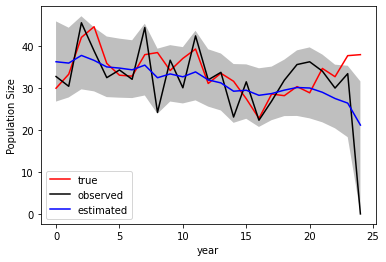

In [252]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, n_years):
    fitted[i] = np.mean(jags_prior_samples['N.est'][i])
    lower[i] = np.quantile(jags_prior_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_prior_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

In [257]:
np.repeat(50, 25)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50])

In [258]:
## 5.3




In [271]:
n_years = 25
N = np.repeat(50, n_years)

p = 0.7
y = np.zeros(25)

for t in range(0, n_years):
    y[t] = np.random.binomial(N[t], p, 1)


In [272]:
jags_data = {
    "y": y,
    "T": n_years
}

In [285]:
inits = {}

inits['sigma.proc'] = np.random.uniform(0, 5, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)

In [286]:
parameters = ['lambda', 'mean.lambda', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [287]:
model5_3 = pyjags.Model(
    code = simple_model_code,
    data = jags_data,
    chains = 3, 
    init = inits
)

jags_samples = jags_simple_model.sample(25000, vars=parameters)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [293]:
jags_samples = jags_simple_model.sample(25000, vars=parameters)

sampling: iterations 67458 of 75000, elapsed 0:00:05, remaining 0:00:01
sampling: iterations 75000 of 75000, elapsed 0:00:06, remaining 0:00:00


In [304]:
idata = az.from_pyjags(jags_samples)

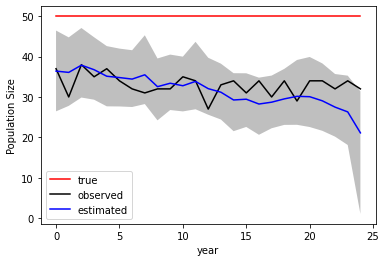

In [306]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, n_years):
    fitted[i] = np.mean(jags_prior_samples['N.est'][i])
    lower[i] = np.quantile(jags_prior_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_prior_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

In [314]:
#5.4

n_years = 25
N = np.repeat(50, n_years)

lp = [-0.5 + 0.1 * x for x in range(0, n_years)]
p = scipy.stats.norm.cdf(lp)

y = np.zeros(25)

for t in range(0, n_years):
     y[t] = np.random.binomial(N[t], p[t], 1)


In [316]:
jags_data = {
    "y": y,
    "T": n_years
}

In [319]:
model5_4 = pyjags.Model(
    code = simple_model_code,
    data = jags_data,
    chains = 3, 
    init = inits
)

jags_samples = model5_4.sample(25000, vars=parameters)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 75000 of 75000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 75000 of 75000, elapsed 0:00:06, remaining 0:00:00


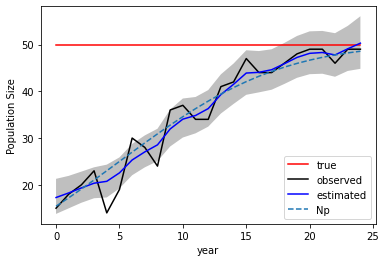

In [322]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, n_years):
    fitted[i] = np.mean(jags_samples['N.est'][i])
    lower[i] = np.quantile(jags_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.plot(N*p, label='Np', linestyle='dashed')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

# 5.4. Real example

In [ ]:
'''
model {

    
    
    # priors and constraints
    N.est[1] ~ dunif(0, 500) # prior for initial pop size
    mean.lambda ~ dunif(0, 10) #prior for the mean growth rate
    sigma.proc ~ dunif(0, 10) # prior for sd of state process
    sigma2.proc <- pow(sigma.proc, 2)
    tau.proc <- pow(sigma.proc, -2)
    sigma.obs ~ dunif(0, 100) # prior for sd of observation process
    sigma2.obs <- pow(sigma.obs, 2)
    tau.obs <- pow(sigma.obs, -2)

    # likelihood

    # state process
    for (t in 1:(T-1)){
        lambda[t] ~ dnorm(mean.lambda, tau.proc)
        N.est[t+1] <- N.est[t] * lambda[t]
    }

    #observation process
    for (t in 1:T) {
        y[t] ~ dnorm(N.est[t], tau.obs)
    }
}
'''

In [324]:
real_model = '''
model = {
    # priors and constraints
    logN.est[1] ~ dnorm(5.6, 0.01)  # prior for init. pop. size
    mean.r ~ dnorm(1, 0.001)        # prior for mean growth rate
    sigma.proc ~ dunif(0, 1)        # prior for sd of state process
    sigma2.proc ~ pow(sigma.proc, 2)
    tau.proc <- pow(sigma.proc, -2)
    sigma.obs ~ dunif(0, 1)         # prior for sd of obs. process
    sigma2.osbs <- pow(sigma.obs, 2)
    tau.obs <- pow(sigma.obs - 2)

    # likelihood
    # State process

    for (t in 1:(T-1)){
        r[t] ~ dnorm(mean.r, tau.proc)
        logN.est[t+1] <- logN.est[t] + r[t]
    }

    # observation process
    for (t in 1:T) {
        y[t] ~ dnorm(logN.est[t], tau.obs)
    }

    # population sizes on real scale
    for (t in 1:T) {
        N.est[t] <- exp(logN.est[t])
    }
}


'''

In [339]:
# House martin population data from Magden
p_years = 6 # Number of future years with predictions
B = np.zeros(p_years)
B[:] = np.nan

A = np.array([271, 261, 309, 318, 231, 216, 208, 226, 195, 226, 233, 209, 226, 192, 191, 225, 245, 205, 191, 174])

hm = np.concatenate([A, B])
years = range(1990, 2009+p_years)

In [341]:
jags_data = {
    "y": np.log(hm),
    "T": len(years)
}

In [ ]:
inits = {}

inits['sigma.proc'] = np.random.uniform(0, 1, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)